In [1]:
from math import sqrt
from numpy import concatenate
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot

from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

Using TensorFlow backend.


In [2]:
df = read_csv('Final_Data.csv', delimiter=',',engine = 'python', index_col=0)
df.head()

,Polarity,Sensitivity,Tweet_vol,Open,High,Low,Close_Price,Volume_BTC,Volume_Dollar
2018-07-11 20:00:00,0.102657,0.216148,4354.0,6342.97,6354.19,6291.00,6350.00,986.73,6231532.37
2018-07-11 21:00:00,0.098004,0.218612,4432.0,6352.99,6370.00,6345.76,6356.48,126.46,804221.55
2018-07-11 22:00:00,0.096688,0.231342,3980.0,6350.85,6378.47,6345.00,6361.93,259.10,1646353.87
2018-07-11 23:00:00,0.103997,0.217739,3830.0,6362.36,6381.25,6356.74,6368.78,81.54,519278.69
2018-07-12 00:00:00,0.094383,0.195256,3998.0,6369.49,6381.25,6361.83,6380.00,124.55,793560.22


In [3]:
df = df[['Close_Price', 'Polarity', 'Sensitivity','Tweet_vol','Volume_BTC']]
df.head()

,Close_Price,Polarity,Sensitivity,Tweet_vol,Volume_BTC
2018-07-11 20:00:00,6350.00,0.102657,0.216148,4354.0,986.73
2018-07-11 21:00:00,6356.48,0.098004,0.218612,4432.0,126.46
2018-07-11 22:00:00,6361.93,0.096688,0.231342,3980.0,259.10
2018-07-11 23:00:00,6368.78,0.103997,0.217739,3830.0,81.54
2018-07-12 00:00:00,6380.00,0.094383,0.195256,3998.0,124.55


In [4]:
values = df.values
cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]
df = df[['Close_Price', 'Polarity', 'Sensitivity','Tweet_vol','Volume_BTC']]
df.head()

,Close_Price,Polarity,Sensitivity,Tweet_vol,Volume_BTC
2018-07-11 20:00:00,6350.00,0.102657,0.216148,4354.0,986.73
2018-07-11 21:00:00,6356.48,0.098004,0.218612,4432.0,126.46
2018-07-11 22:00:00,6361.93,0.096688,0.231342,3980.0,259.10
2018-07-11 23:00:00,6368.78,0.103997,0.217739,3830.0,81.54
2018-07-12 00:00:00,6380.00,0.094383,0.195256,3998.0,124.55


In [5]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df.values)
n_hours = 3 #adding 3 hours lag 
n_features = 5 #No. of Features
n_obs = n_hours*n_features

In [6]:
reframed = series_to_supervised(scaled, n_hours, 1)
reframed.head()

,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t),var2(t),var3(t),var4(t),var5(t)
3,0.125479,0.611105,0.429055,0.181916,0.368430,0.129527,0.555312,0.454335,0.192380,0.039893,0.132931,0.539534,0.584943,0.131741,0.090548,0.137210,0.627175,0.445375,0.111618,0.022738
4,0.129527,0.555312,0.454335,0.192380,0.039893,0.132931,0.539534,0.584943,0.131741,0.090548,0.137210,0.627175,0.445375,0.111618,0.022738,0.144218,0.511893,0.214693,0.134156,0.039164
5,0.132931,0.539534,0.584943,0.131741,0.090548,0.137210,0.627175,0.445375,0.111618,0.022738,0.144218,0.511893,0.214693,0.134156,0.039164,0.135117,0.589271,0.500135,0.095922,0.045637
6,0.137210,0.627175,0.445375,0.111618,0.022738,0.144218,0.511893,0.214693,0.134156,0.039164,0.135117,0.589271,0.500135,0.095922,0.045637,0.111700,0.722717,0.212514,0.113362,0.045561
7,0.144218,0.511893,0.214693,0.134156,0.039164,0.135117,0.589271,0.500135,0.095922,0.045637,0.111700,0.722717,0.212514,0.113362,0.045561,0.111101,0.649855,0.365349,0.111752,0.053607


In [7]:
reframed.drop(reframed.columns[-4], axis=1)
reframed.head()

,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t),var2(t),var3(t),var4(t),var5(t)
3,0.125479,0.611105,0.429055,0.181916,0.368430,0.129527,0.555312,0.454335,0.192380,0.039893,0.132931,0.539534,0.584943,0.131741,0.090548,0.137210,0.627175,0.445375,0.111618,0.022738
4,0.129527,0.555312,0.454335,0.192380,0.039893,0.132931,0.539534,0.584943,0.131741,0.090548,0.137210,0.627175,0.445375,0.111618,0.022738,0.144218,0.511893,0.214693,0.134156,0.039164
5,0.132931,0.539534,0.584943,0.131741,0.090548,0.137210,0.627175,0.445375,0.111618,0.022738,0.144218,0.511893,0.214693,0.134156,0.039164,0.135117,0.589271,0.500135,0.095922,0.045637
6,0.137210,0.627175,0.445375,0.111618,0.022738,0.144218,0.511893,0.214693,0.134156,0.039164,0.135117,0.589271,0.500135,0.095922,0.045637,0.111700,0.722717,0.212514,0.113362,0.045561
7,0.144218,0.511893,0.214693,0.134156,0.039164,0.135117,0.589271,0.500135,0.095922,0.045637,0.111700,0.722717,0.212514,0.113362,0.045561,0.111101,0.649855,0.365349,0.111752,0.053607


In [8]:
values = reframed.values
n_train_hours = 200
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
train.shape

(200, 20)

In [9]:
#Train Test Split
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]

In [10]:
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(200, 3, 5) (200,) (91, 3, 5) (91,)


In [11]:
model = Sequential()
model.add(LSTM(5, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

Instructions for updating:
Colocations handled automatically by placer.


In [12]:
#Training
history = model.fit(train_X, train_y, epochs=50, batch_size=6, validation_data=(test_X, test_y), verbose=2, shuffle=False,validation_split=0.2)

Instructions for updating:
Use tf.cast instead.
Train on 200 samples, validate on 91 samples
Epoch 1/50
 - 9s - loss: 0.3806 - val_loss: 0.9704
Epoch 2/50
 - 1s - loss: 0.3477 - val_loss: 0.9009
Epoch 3/50
 - 1s - loss: 0.3358 - val_loss: 0.8543
Epoch 4/50
 - 1s - loss: 0.3233 - val_loss: 0.8153
Epoch 5/50
 - 1s - loss: 0.3132 - val_loss: 0.7861
Epoch 6/50
 - 1s - loss: 0.3029 - val_loss: 0.7591
Epoch 7/50
 - 1s - loss: 0.2933 - val_loss: 0.7333
Epoch 8/50
 - 1s - loss: 0.2845 - val_loss: 0.7083
Epoch 9/50
 - 1s - loss: 0.2765 - val_loss: 0.6853
Epoch 10/50
 - 1s - loss: 0.2686 - val_loss: 0.6628
Epoch 11/50
 - 1s - loss: 0.2609 - val_loss: 0.6404
Epoch 12/50
 - 1s - loss: 0.2538 - val_loss: 0.6194
Epoch 13/50
 - 1s - loss: 0.2464 - val_loss: 0.5985
Epoch 14/50
 - 1s - loss: 0.2390 - val_loss: 0.5771
Epoch 15/50
 - 1s - loss: 0.2316 - val_loss: 0.5552
Epoch 16/50
 - 1s - loss: 0.2239 - val_loss: 0.5323
Epoch 17/50
 - 1s - loss: 0.2160 - val_loss: 0.5080
Epoch 18/50
 - 1s - loss: 0.2075

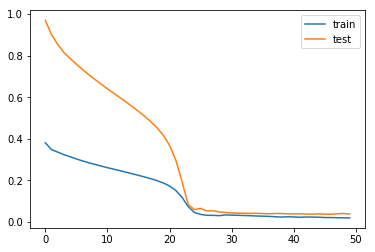

In [13]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [14]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours* n_features,))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -4:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -4:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
mse = (mean_squared_error(inv_y, inv_yhat))
print('Test MSE: %.3f' % mse)
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test MSE: 5548.750
Test RMSE: 74.490


In [15]:
# importing new data for testing
df_new = read_csv('extra_final.csv', delimiter=',',engine = 'python', index_col=0)
df_new = df_new[['Close_Price', 'Polarity', 'Sensitivity','Tweet_vol','Volume_BTC']]
values = df_new.values
cols = df_new.columns.tolist()
cols = cols[-1:] + cols[:-1]
df_new = df[cols]
df_new = df[['Close_Price', 'Polarity', 'Sensitivity','Tweet_vol','Volume_BTC']]
df_new.head()

,Close_Price,Polarity,Sensitivity,Tweet_vol,Volume_BTC
2018-07-11 20:00:00,6350.00,0.102657,0.216148,4354.0,986.73
2018-07-11 21:00:00,6356.48,0.098004,0.218612,4432.0,126.46
2018-07-11 22:00:00,6361.93,0.096688,0.231342,3980.0,259.10
2018-07-11 23:00:00,6368.78,0.103997,0.217739,3830.0,81.54
2018-07-12 00:00:00,6380.00,0.094383,0.195256,3998.0,124.55


In [17]:
inv_yhat = concatenate((yhat, test_X[:, -4:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -4:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
print('Test MSE: %.3f' % mse_new)
rmse_new = sqrt(mse_new)
print('Test RMSE: %.3f' % rmse_new)

Test MSE: 4508.750
Test RMSE: 67.147
